# Adult Census Income Prediction

## Project Goal

The goal of this project is to predict whether an individual's income exceeds $50,000 per year based on census data. This notebook will cover the entire machine learning pipeline, from data loading and cleaning to exploratory data analysis (EDA), feature engineering, and finally, model training and evaluation.

We will focus on building a robust and reproducible workflow, using a custom library for preprocessing and analysis, and providing clear visualizations and explanations at each step.

## Pipeline Overview

1. Load & Clean Data
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Encoding Categorical Variables
5. Model Training (Logistic Regression, Decision Tree, etc.)
6. Evaluation (Accuracy, Precision, Recall)
7. Comparison Across Encodings

# Main Notebook
This notebook is for the main analysis and experimentation.

## 1 Load & Clean Data


### 1.1 Load Data

In [198]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Add the repo root to access the courselib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
courselib_path = os.path.join(repo_root, "AppliedML", "courselib")
if courselib_path not in sys.path:
    sys.path.insert(0, courselib_path)
    print(f"{courselib_path} added to sys.path.")
else:
    print("Courselib path already in sys.path.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Courselib path already in sys.path.


As this project is supposed to integrate well with the courselib, we have downloaded the current GitHub Repo up to week 11 and our code will be integrated within courselib libraries.

In [199]:
from utils.loaders import load_uciadult

# ensure the data directory exists / else create it
os.makedirs('data', exist_ok=True)

# get the data
df = load_uciadult()

Loading from local `data/adult.data`...


In [200]:
# check for missing values
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

### 1.2 Data Cleaning

1.  **Handle Duplicates**: We remove any duplicate rows from the dataset.
2.  **Handle Missing Values**: Rather than dropping rows with missing values, we treat them as a separate category labeled `"Missing"` in all categorical columns. This allows us to preserve potentially useful information — for example, individuals with unknown workclass or occupation might share certain income patterns. This approach is especially appropriate for categorical variables, where missingness itself may carry signal.


In [201]:
from utils.preprocessing import preprocess_data

# preprocessing of  the data
df = preprocess_data(df)

24 duplicate observations in the dataset were removed.


In [202]:
# first glimpse into the data set
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# 2. Exploratory Data Analysis (EDA)

In [203]:
# basic info about the data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32537 non-null  int64   
 1   workclass       32537 non-null  category
 2   fnlwgt          32537 non-null  int64   
 3   education       32537 non-null  category
 4   education-num   32537 non-null  int64   
 5   marital-status  32537 non-null  category
 6   occupation      32537 non-null  category
 7   relationship    32537 non-null  category
 8   race            32537 non-null  category
 9   sex             32537 non-null  category
 10  capital-gain    32537 non-null  int64   
 11  capital-loss    32537 non-null  int64   
 12  hours-per-week  32537 non-null  int64   
 13  native-country  32537 non-null  category
 14  income          32537 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 2.2 MB


In [204]:
# summary stats about the variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329,0.240926
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889,0.427652
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


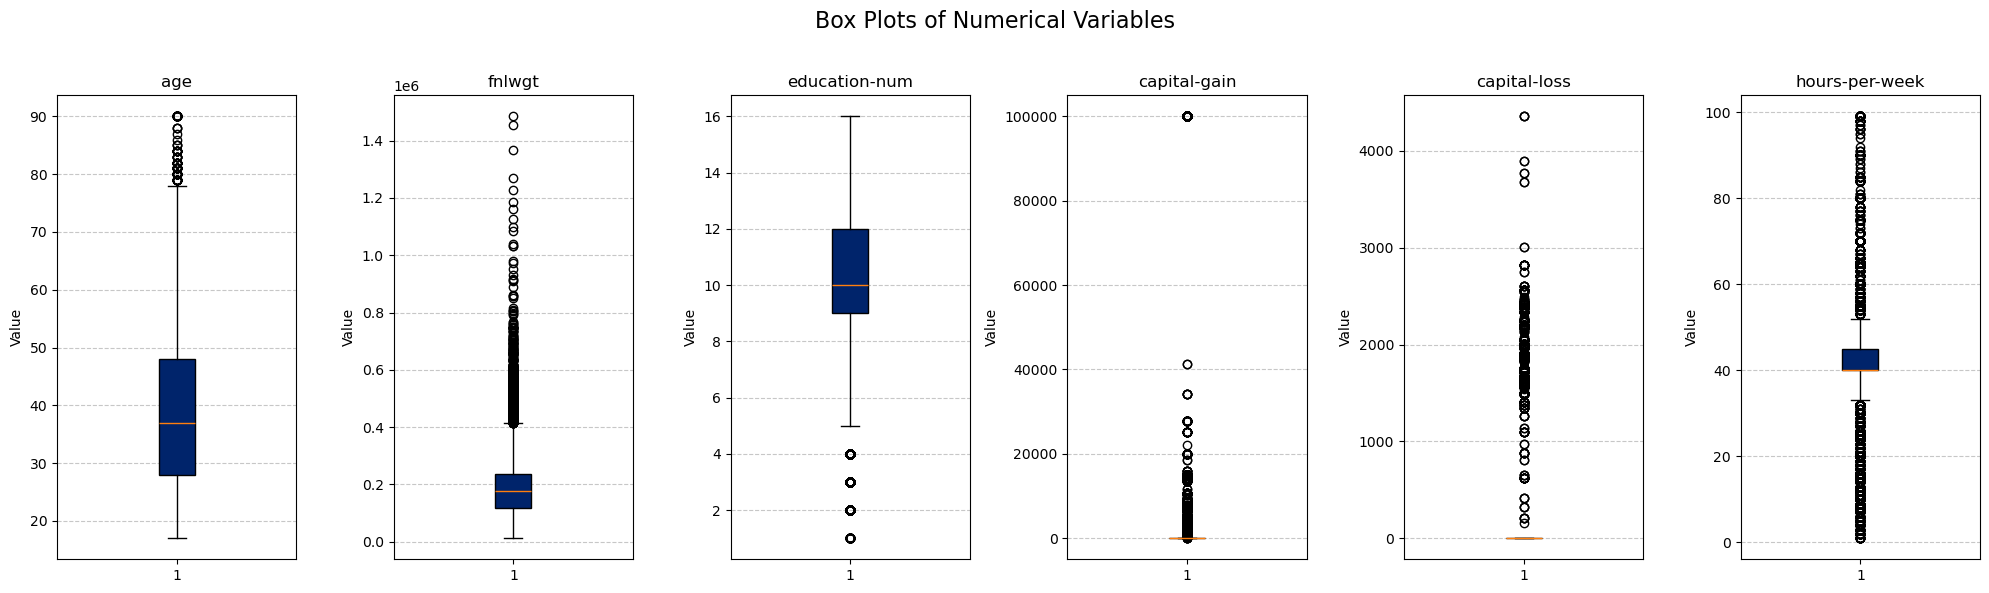

In [205]:
# boxplots of the numerical cols 
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'income' in numerical_cols:
    numerical_cols.remove('income')

# grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(20, 6))
fig.suptitle('Box Plots of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    ax.boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='#00246B'))
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Value')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- High Skewness: `fnlwgt`, `capital-gain`, and `capital-loss` are heavily right-skewed. For `capital-gain`, and `capital-loss`, the majority of values are zero, with a few very large outliers. This indicates that these events are rare but have a high magnitude when they occur. `fnlwgt`is dropped as that variable is difficult to interpret. (It indicates how many people in the population a particular record represents and is therefore not an individual attribute and also highly skewed with high variance.)
- Moderate Outliers: age and hours-per-week also show outliers but have more symmetric distributions.

In [206]:
from utils.preprocessing import transform_skewed_features

# skewed columns and apply transformation
skewed_cols = ['capital-gain', 'capital-loss']
df = transform_skewed_features(df, skewed_cols)
df.drop('fnlwgt', axis=1, inplace=True)

log1p transformation and binary indicators for: ['capital-gain', 'capital-loss']


The following chart shows a class imbalance in the data: approximately 76% of individuals earn <=50K (low-earners = 0) while only 24% earn >50K (high-earners = 1). A model trained on this data might become biased towards predicting the majority class. Standard accuracy can be a misleading metric; a naive model that always predicts <=50K would be ~76% accurate but completely useless.

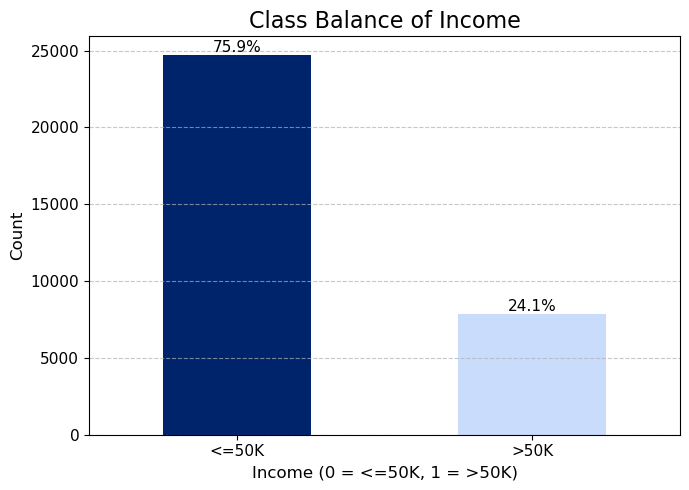

In [207]:
# distribution of the target variable
plt.figure(figsize=(7, 5))
bars = df['income'].value_counts().sort_index().plot(
    kind='bar',
    color=['#00246B', '#CADCFC'],
)
plt.title('Class Balance of Income', fontsize=16)
plt.xlabel('Income (0 = <=50K, 1 = >50K)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
counts = df['income'].value_counts().sort_index()
labels = ['<=50K', '>50K']
for i, count in enumerate(counts):
    pct = count / counts.sum() * 100
    plt.text(i, count + 200, f'{pct:.1f}%', ha='center', fontsize=11)
plt.show()

The age distribution shows that individuals earning over $50K are, on average, older than those earning less. The high-income group's distribution peaks between the late 30s and early 50s, suggesting that income potential increases with age and experience before declining.

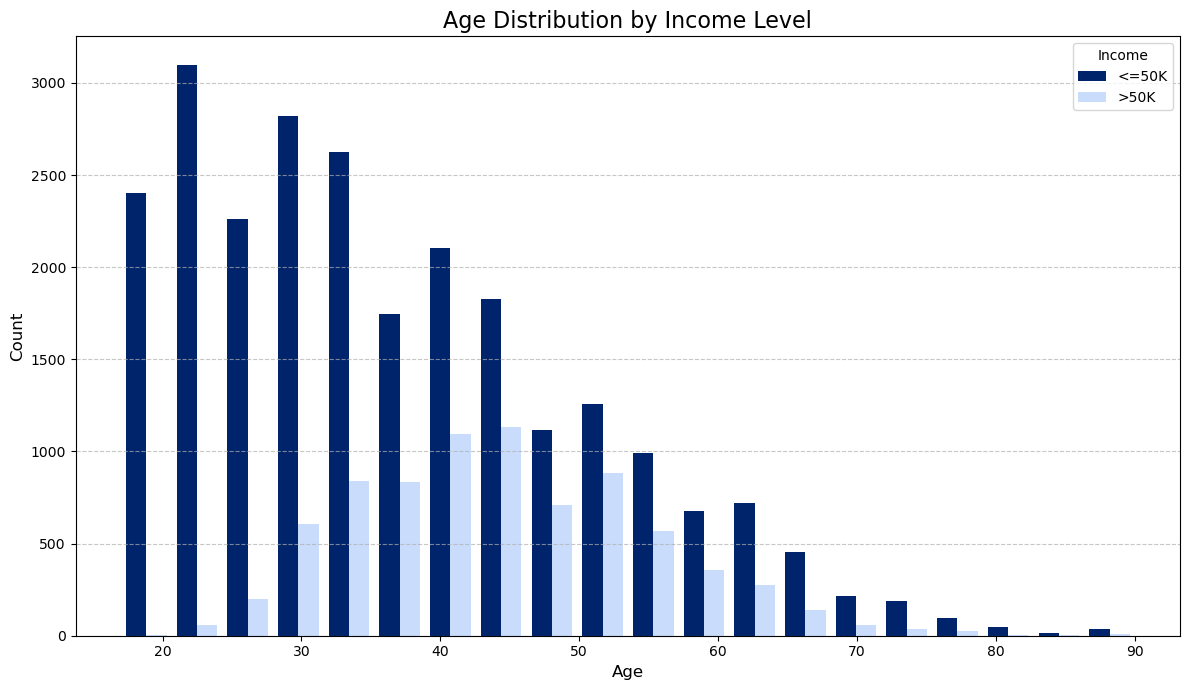

In [208]:
# relationship between income and age
plt.figure(figsize=(12, 7))

# separate data for the two income categories
over50k = df[df['income'] == 0]['age']
below50k = df[df['income'] == 1]['age']

# side-by-side histograms
plt.hist([over50k, below50k], bins=20, color=['#00246B', '#CADCFC'], label=['<=50K', '>50K'])
plt.title('Age Distribution by Income Level', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Income')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There seems to exist a strong, positive correlation between education and income. The likelihood of earning over $50K increases directly with the level of education, which seems economically reasonable. This clear ordering suggests the use of ordinal encoding for this feature.

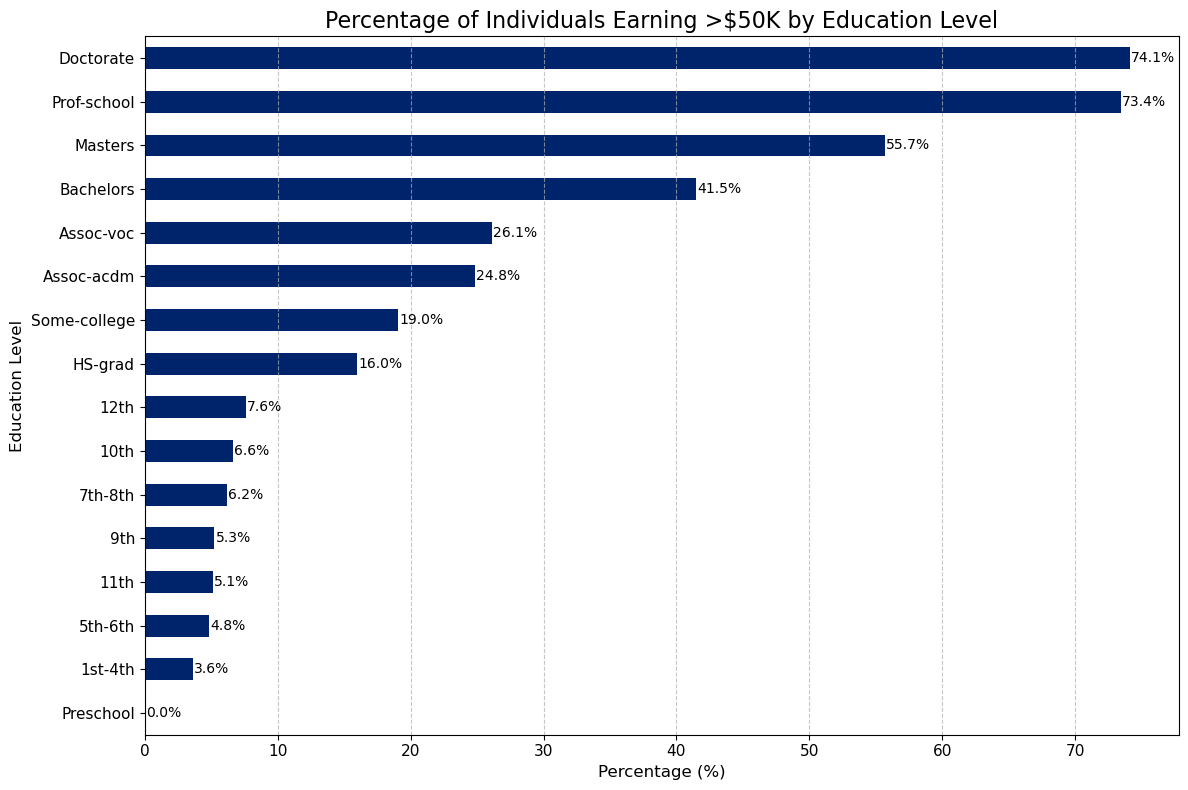

In [209]:
education_income_pct = df.groupby('education', observed=False)['income'].mean().sort_values() * 100

# plot
plt.figure(figsize=(12, 8))
bars = education_income_pct.plot(kind='barh', color='#00246B')
plt.title('Percentage of Individuals Earning >$50K by Education Level', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# percentage labels
for bar in bars.patches:
    plt.text(bar.get_width() + 0.1,
             bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f}%',
             va='center',
             ha='left',
             fontsize=10)

plt.tight_layout()
plt.show()

This chart shows the average hours worked per week for each workclass, with bar color indicating the proportion of high-income earners. `Self-emp-inc` stands out with both the highest average hours and the greatest income potential (55.7%). Conversely, categories like `Without-pay` and `Never-worked` show zero high-income potential. The `Missing` category also has a low income potential (10.4%), suggesting that the reason for the missing data might be correlated with lower-paying or non-standard work situations.

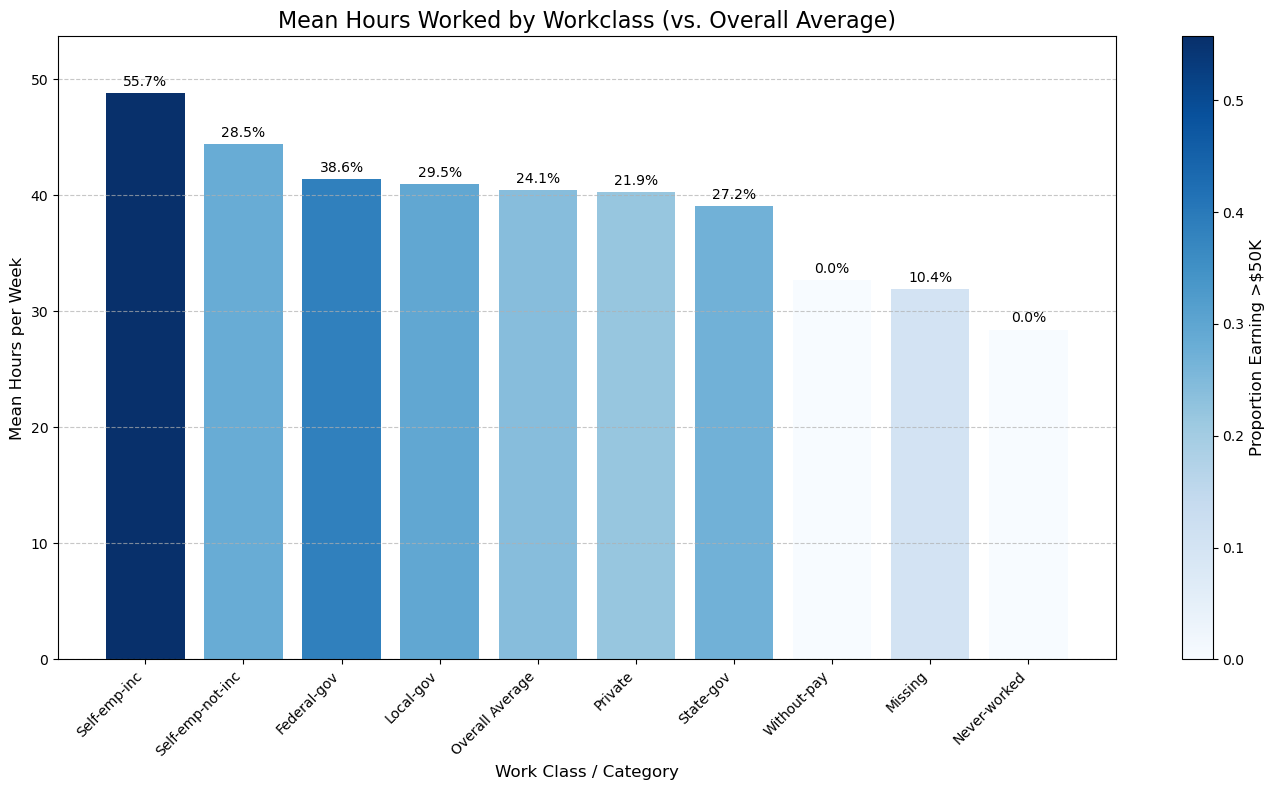

In [210]:
workclass_stats = df.groupby('workclass', observed=False).agg(
    mean_hours=('hours-per-week', 'mean'),
    pct_high_income=('income', 'mean')
)
overall_stats = pd.DataFrame({
    'mean_hours': [df['hours-per-week'].mean()],
    'pct_high_income': [df['income'].mean()]
}, index=['Overall Average'])

# merge workclass stats with overall stats
combined_stats = pd.concat([workclass_stats, overall_stats]).sort_values('mean_hours', ascending=False)

# plot and colormap
fig, ax = plt.subplots(figsize=(14, 8))
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=combined_stats['pct_high_income'].min(), vmax=combined_stats['pct_high_income'].max())
colors = cmap(norm(combined_stats['pct_high_income'].values))
bars = ax.bar(combined_stats.index, combined_stats['mean_hours'], color=colors)

# color bar for the mean proportion of high-earners
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.05)
cbar.set_label('Proportion Earning >$50K', fontsize=12)

# text labels for the proportions
labels = [f'{pct*100:.1f}%' for pct in combined_stats['pct_high_income']]
ax.bar_label(bars, labels=labels, padding=3, fontsize=10, color='black')
ax.set_title('Mean Hours Worked by Workclass (vs. Overall Average)', fontsize=16)
ax.set_xlabel('Work Class / Category', fontsize=12)
ax.set_ylabel('Mean Hours per Week', fontsize=12)
ax.set_ylim(0, combined_stats['mean_hours'].max() * 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

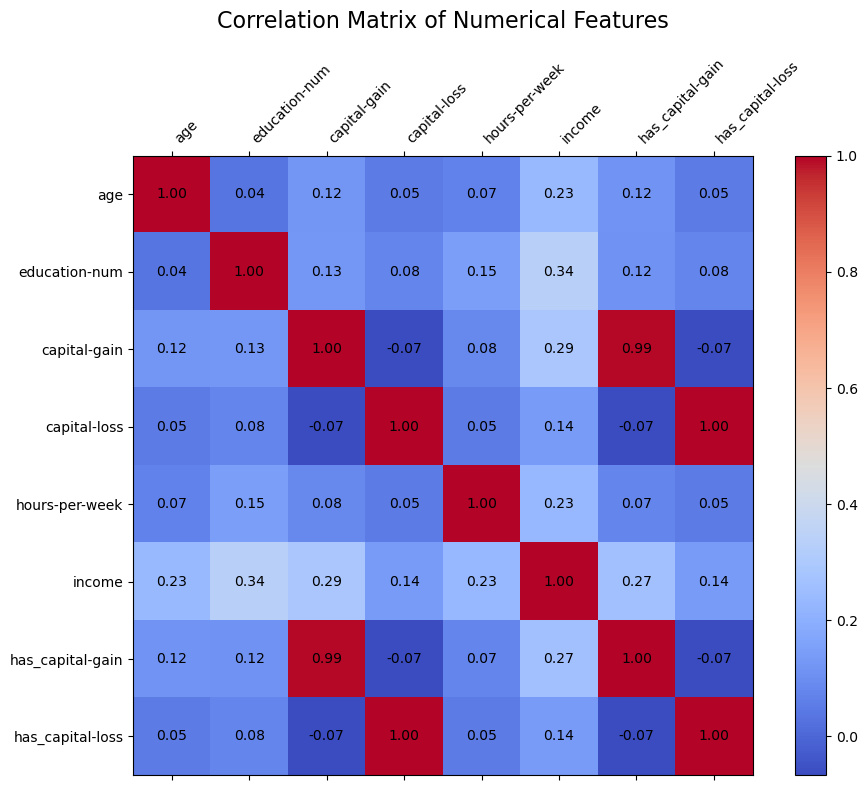

In [211]:
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

# Add a color bar
fig.colorbar(cax)

# Add the correlation values as text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=10)

# Set the ticks and labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(correlation_matrix.columns)

plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


# 3. Feature Engineering


In [212]:
# counts and proportions of every categorical col
categorical_cols_merged = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols_merged:
    print(f"--- Feature: {col} ---")
    
    # summary of each group within a col
    summary_df = pd.DataFrame({
        'Count': df[col].value_counts(),
        'Proportion (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })
    print(summary_df)
    print("_"*40 + "\n")

--- Feature: workclass ---
                  Count  Proportion (%)
workclass                              
Private           22673           69.68
Self-emp-not-inc   2540            7.81
Local-gov          2093            6.43
Missing            1836            5.64
State-gov          1298            3.99
Self-emp-inc       1116            3.43
Federal-gov         960            2.95
Without-pay          14            0.04
Never-worked          7            0.02
________________________________________

--- Feature: education ---
              Count  Proportion (%)
education                          
HS-grad       10494           32.25
Some-college   7282           22.38
Bachelors      5353           16.45
Masters        1722            5.29
Assoc-voc      1382            4.25
11th           1175            3.61
Assoc-acdm     1067            3.28
10th            933            2.87
7th-8th         645            1.98
Prof-school     576            1.77
9th             514            1

### 3.1 Category Merging

Before encoding, we will merge some categories to reduce dimensionality and group similar items to simplify features and help the model generalize better. Thus several possible categorical variables are analyzed and discussed.


In [213]:
# to modify the dataset
df = df.copy()

In [214]:
# binary feature for US vs. rest of the world as the dataset is mostly US-related
df['is_from_us'] = (df['native-country'] == 'United-States').astype(int)
df.drop('native-country', axis=1, inplace=True)
print("Value counts for 'is_from_us':\n")
print(df['is_from_us'].value_counts())

Value counts for 'is_from_us':

is_from_us
1    29153
0     3384
Name: count, dtype: int64


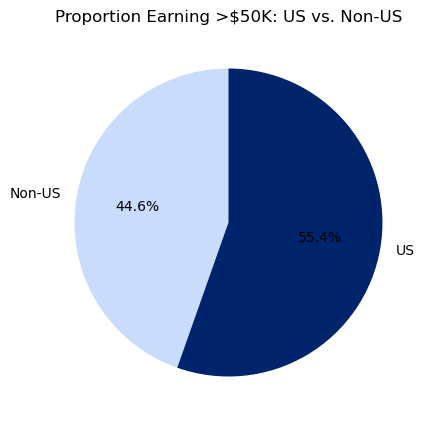

In [215]:
# pie chart for US vs. Non-US
us_vs_nonus = df.groupby('is_from_us')['income'].mean()
labels = ['Non-US', 'US']
plt.figure(figsize=(5, 5))
plt.pie(us_vs_nonus, labels=labels, autopct='%1.1f%%', colors=['#CADCFC', '#00246B'], startangle=90)
plt.title('Proportion Earning >$50K: US vs. Non-US')
plt.show()

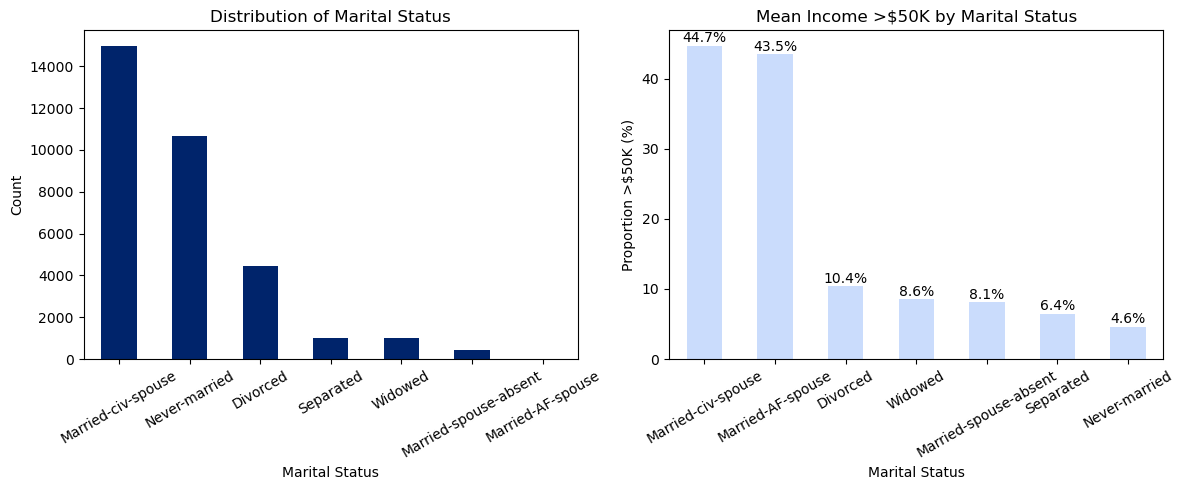

In [216]:
# mean income by marital status

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count of each marital status
marital_counts = df['marital-status'].value_counts().sort_values(ascending=False)
marital_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Marital Status')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# Mean income by marital status
marital_income = df.groupby('marital-status', observed=False)['income'].mean().sort_values(ascending=False) * 100
marital_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Marital Status')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(marital_income):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

The plot suggests that creating a binary feature for married vs. non-married, although we will treat the group Married-spouse-absent, i.e. legally married but not living with spouse (spouse is absent, e.g., separated but not divorced) as non-married.

In [217]:
married_statuses = ['Married-civ-spouse', 'Married-AF-spouse']
df['is_married'] = df['marital-status'].isin(married_statuses).astype(int)
df.drop('marital-status', axis=1, inplace=True)
print("\nValue counts for the new 'is_married' feature:\n")
print(df['is_married'].value_counts())


Value counts for the new 'is_married' feature:

is_married
0    17544
1    14993
Name: count, dtype: int64


In [218]:
# merge husband and wife into spouse in relationship variable to further reduce cardinality for onehot encoding
df['relationship'] = df['relationship'].astype(str).replace({'Husband': 'Spouse', 'Wife': 'Spouse'}).astype('category')

# merge without-pay, never-worked categories into other to further reduce cardinality for onehot encoding
df['workclass'] = df['workclass'].astype(str).replace(['Without-pay', 'Never-worked'], 'Other').astype('category')

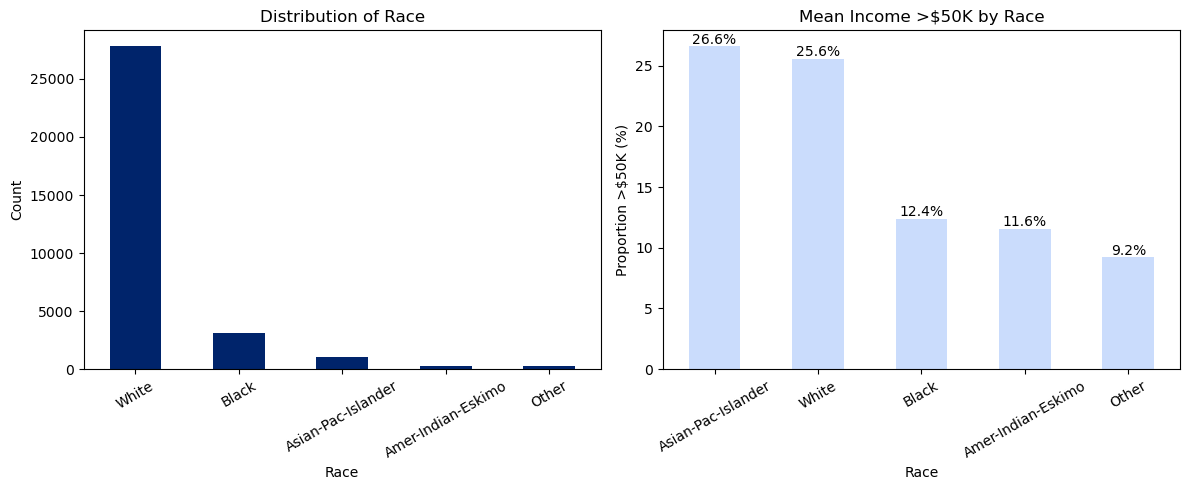

In [219]:
# race distribution and mean income by race
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# count of each race
race_counts = df['race'].value_counts().sort_values(ascending=False)
race_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# mean income by race
race_income = df.groupby('race', observed=False)['income'].mean().sort_values(ascending=False) * 100
race_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Race')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(race_income):
    axes[1].text(i, v + 0.2, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [220]:
# merge Amer-Indian-Eskimo and Other categories into other to further reduce cardinality for onehot encoding
df['race'] = df['race'].astype(str).replace({'Amer-Indian-Eskimo': 'Other'}).astype('category')

In [221]:
# number of distinct values in our categorical cols -> what feature encoding strat to use
categorical_vars = ['workclass', 'relationship', 'race', 'sex', 'education', 'occupation']

for var in categorical_vars:
    if var in df.columns:
        unique_vals = df[var].unique()
        print(f"{var}: {len(unique_vals)} unique values:\n {list(unique_vals)}\n")

workclass: 8 unique values:
 ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'Missing', 'Self-emp-inc', 'Other']

relationship: 5 unique values:
 ['Not-in-family', 'Spouse', 'Own-child', 'Unmarried', 'Other-relative']

race: 4 unique values:
 ['White', 'Black', 'Asian-Pac-Islander', 'Other']

sex: 2 unique values:
 ['Male', 'Female']

education: 16 unique values:
 ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']

occupation: 15 unique values:
 ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'Missing', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv']



The merging of categories in features like race, relationship, and workclass leads to only a small reduction in dimensionality, but is justified because the combined groups are both small and statistically similar in terms of income distribution. This reduces noise and the risk of overfitting, while preserving the main socioeconomic patterns in the data. By merging only where appropriate, we maintain interpretability and model performance without unnecessary simplification.

### Feature Encoding strategies

Feature encoding transforms categorical variables into numerical values for machine learning models. Here are the main strategies used, with mathematical formulas and quick examples:

---

#### 1. One-Hot Encoding

- **Def.:** For a feature with $k$ categories, create $k-1$ binary columns:
  $$
  \text{OneHot}(x = c_j) = [0, \ldots, 1, \ldots, 0] \in \mathbb{R}^{k-1}
  $$
  where the $j$-th position is $1$ if $x = c_j$, else $0$.
- **Example:** If `race` has categories `[White, Black, Asian]` and $x = \text{Black}$, then $\text{OneHot}(x) = [1, 0]$.
- **When/Why:** Use for nominal (unordered) features to avoid implying order. We create $k-1$ columns instead of $k$ to avoid **perfect multicollinearity**, where one feature can be perfectly predicted by the others. This is crucial for linear models. The dropped category  (the most frequent one) becomes the baseline reference.

---

#### 2. Ordinal Encoding

- **Def.:** Map ordered categories to integers:
  $$
  \text{Ordinal}(x = c_j) = j
  $$
  where $j$ is the position in the predefined order.
- **Example:** If `education` order is `[HS-grad, Bachelors, Masters]$ and $x = \text{Bachelors}$, then $\text{Ordinal}(x) = 1$.
- **When/Why:** Use for ordinal features where order matters.

---

#### 3. Target Encoding

- **Def.:** Replace each category with the mean target value:
  $$
  \text{TargetEnc}(x = c_j) = \mathbb{E}[y \mid x = c_j]
  $$
- **Example:** If mean income for `occupation = Tech` is $0.32$, then $\text{TargetEnc}(\text{Tech}) = 0.32$.
- **When/Why:** Use for high-cardinality features; captures target signal but risk of leakage (use cross-validation).

---

#### 4. Frequency Encoding

- **Def.:** Replace each category with its frequency:
  $$
  \text{FreqEnc}(x = c_j) = \frac{\text{count}(x = c_j)}{N}
  $$
  where $N$ is the total number of samples.
- **Example:** If `country = US` appears in $70\%$ of rows, then $\text{FreqEnc}(\text{US}) = 0.7$.
- **When/Why:** Use for high-cardinality features; simple, no leakage.

In [222]:
from utils.preprocessing import encode_features

# encoding strategies for each column we need to encode
encoding_strategies = {
    'one-hot': {'workclass' : 'Private', # second entry is dropped to avoid multicollinearity
                'relationship' : 'Spouse',
                'race' : 'White',
                'sex' : 'Male'},

    'ordinal': {'education': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',
                               'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school',
                               'Doctorate']}, # must contain the correct order already
    'target': ['income', 'occupation'],
    # 'frequency': [], # to later compare with target encoding
  }

# apply the encoding
df_encoded = encode_features(df.copy(), encoding_strategies)
df_encoded.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,has_capital-gain,has_capital-loss,is_from_us,is_married,...,workclass_State-gov,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,race_Asian-Pac-Islander,race_Black,race_Other,sex_Female,occupation_target
0,39,13,7.684784,0.0,40,0,1,0,1,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132761
1,50,13,0.000000,0.0,13,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483191
2,38,9,0.000000,0.0,40,0,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063830
3,53,7,0.000000,0.0,40,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.063830
4,28,13,0.000000,0.0,40,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.453064


In [223]:
#check the shape of the original and encoded dataframes
print("Original df shape:", df.shape)
print("Encoded df shape:", df_encoded.shape)

Original df shape: (32537, 16)
Encoded df shape: (32537, 27)


In [224]:
from utils.splits import train_test_split

# returns the full dataset (X, y) as well as the splits
_, _, X_train, y_train, X_test, y_test = train_test_split(
    df_encoded, 
    training_data_fraction=0.8, 
    class_column_name='income',
    shuffle=True, 
    return_numpy=True
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# balanced of the target variables
print("Train class balance:", np.mean(y_train))
print("Test class balance:", np.mean(y_test))

X_train shape: (26030, 26)
X_test shape: (6507, 26)
y_train shape: (26030,)
y_test shape: (6507,)
Train class balance: 0.24179792547061082
Test class balance: 0.23743660673121253



# Feature Scaling

Before training our models, it's important to scale our numerical features. Of course, it makes no sense to also scale the freshly encoded categorical data, such as the ordinally encoded `education` variable as we would destroy its ordinal structure immediately again.  Models like Logistic Regression are sensitive to the scale of the input data, and scaling can lead to faster convergence and better performance. We will use standardization, where each feature is scaled to have a mean of 0 and a standard deviation of 1.

We will fit the scaler on the training data and use the same scaler to transform the test data. This prevents any information from the test set from leaking into our training process.


In [225]:
df_encoded.columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'has_capital-gain', 'has_capital-loss',
       'is_from_us', 'is_married', 'education_ordinal',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Missing',
       'workclass_Other', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'sex_Female',
       'occupation_target'],
      dtype='object')

In [226]:
from utils.normalization import StandardScaler

# numerical columns for scaling
numerical_cols = ['capital-gain', 'capital-loss', 'age', 'hours-per-week']
X_columns = df_encoded.drop('income', axis=1).columns
numerical_indices = [X_columns.get_loc(col) for col in numerical_cols]

# initialize the scaler with indices of numerical columns
scaler = StandardScaler(numerical_indices=numerical_indices)

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (26030, 26)
X_test_scaled shape: (6507, 26)


## 5. Model Training (Logistic Regression, Decision Tree, SVM)

In this section, we train and evaluate several machine learning models to predict whether an individual's income exceeds $50,000 per year.

### Goal:
To assess the performance of different supervised learning models and compare their effectiveness on the encoded dataset.

### Models Included:
- **Logistic Regression**: A linear model suitable for binary classification, optimized using gradient descent.
- **Decision Tree**: A non-linear model that splits the data hierarchically based on feature values.
- **Linear SVM**: A margin-based classifier that separates classes using a hyperplane, implemented with a custom optimizer.

### Implementation Notes:
- All models are implemented using custom classes from the `courselib` package.
- Logistic Regression and SVM require **numerical input**, so categorical features are encoded appropriately beforehand.
- For SVM training, labels are converted from {0, 1} to {-1, 1}, as required by the hinge loss formulation.

### Evaluation Metrics:
- **Accuracy** on the test set.
- **Training time** to assess computational efficiency.
- **Confusion Matrix** (optional visualizations, commented out to avoid rendering issues).



--- Training Logistic Regression ---
Logistic Regression Accuracy: 23.7437


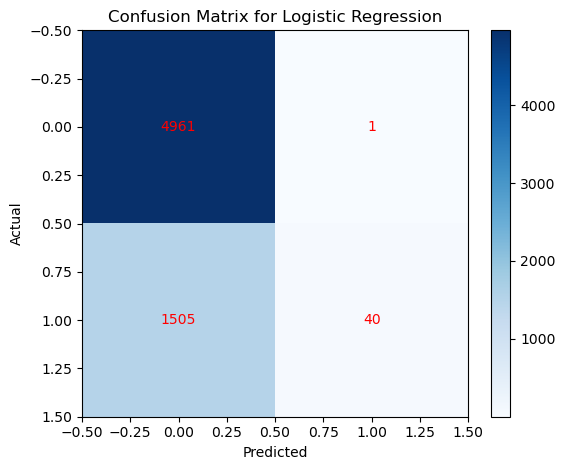



--- Training Decision Tree ---
Decision Tree Accuracy: 23.7437


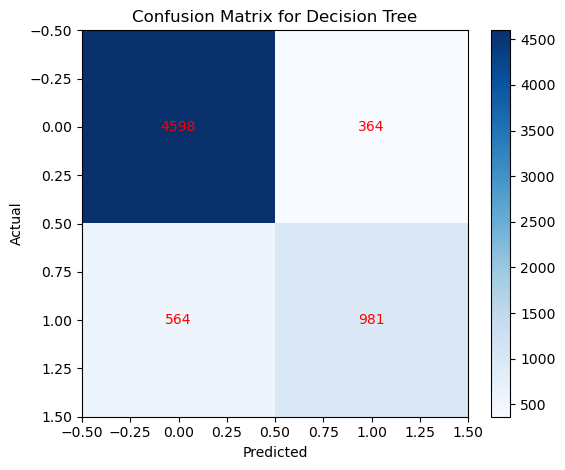



--- Training Linear SVM ---
Linear SVM Accuracy: 23.7437


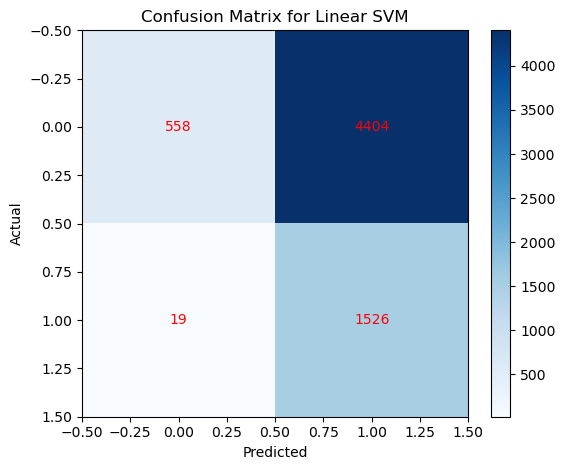



--- Model Comparison Summary ---
                 Model   Accuracy  Training Time (s)
0  Logistic Regression  23.743661           1.133929
1        Decision Tree  23.743661          30.695922
2           Linear SVM  23.743661           1.718779


In [227]:
%pip install cvxopt

import time
from models.linear_models import LinearBinaryClassification
from models.tree import DecisionTreeClassifier
from models.svm import LinearSVM
from optimizers import GDOptimizer
from utils.metrics import binary_accuracy, confusion_matrix

y_train_svm = y_train.copy()
y_train_svm[y_train == 0] = -1

n_features = X_train_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0
optimizer = GDOptimizer(learning_rate=0.01)

models = {
    'Logistic Regression': LinearBinaryClassification(
        w=w_init.copy(),
        b=b_init,
        optimizer=optimizer,
        class_labels=[0, 1]
    ),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=2),
    'Linear SVM': LinearSVM(
        w=w_init.copy(),
        b=b_init,
        optimizer=optimizer,
        C=10.0
    )
}

results = []

for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    start_time = time.time()

    if model_name == 'Linear SVM':
        model.fit(X_train_scaled, y_train_svm, num_epochs=5, batch_size=32)
    elif model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train, num_epochs=5, batch_size=32)
    else:
        model.fit(X_train_scaled, y_train)

    training_time = time.time() - start_time

    try:
        y_pred = model.predict(X_test_scaled)
    except AttributeError:
        y_pred = model(X_test_scaled)
        
    if model_name == 'Linear SVM':
        y_pred = (y_pred == 1).astype(int)
    
    acc = binary_accuracy(y_pred, y_test)
    print(f"{model_name} Accuracy: {acc:.4f}")

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Training Time (s)': training_time
    })
    '''
    from sklearn.metrics import confusion_matrix as sk_confusion_matrix

    cm = sk_confusion_matrix(y_test, y_pred)
    '''
    cm = confusion_matrix(y_test, y_pred, plot=False)

    fig, ax = plt.subplots()
    cax = ax.imshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {model_name}')

    # Annotate cells
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.tight_layout()
    plt.show()
    print("\n" + "="*50 + "\n")

results_df = pd.DataFrame(results)
print("--- Model Comparison Summary ---")
print(results_df)


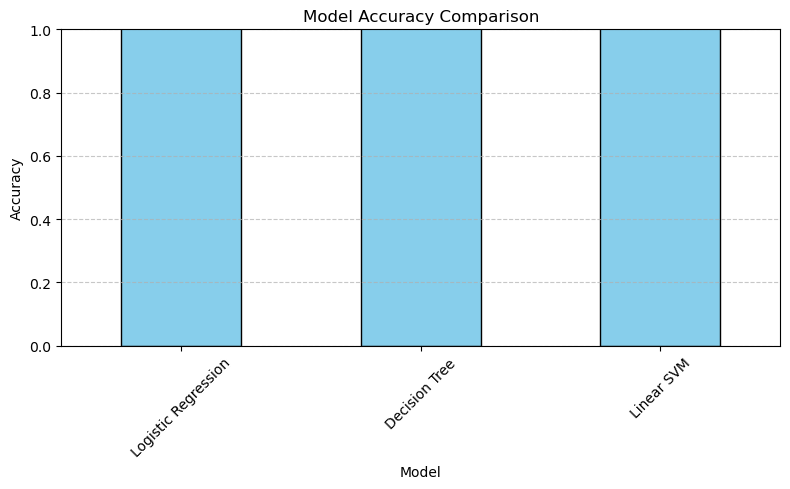

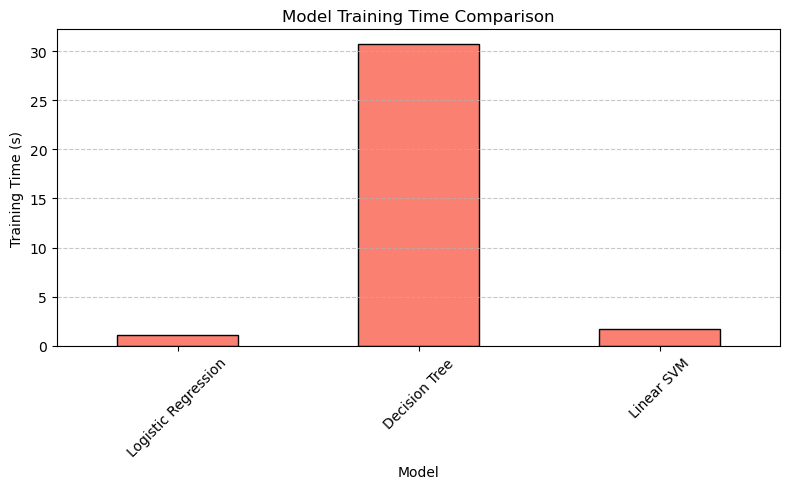

In [228]:
import matplotlib.pyplot as plt

# Bar plot of accuracy
plt.figure(figsize=(8, 5))
results_df.set_index('Model')['Accuracy'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Because accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot of training time
plt.figure(figsize=(8, 5))
results_df.set_index('Model')['Training Time (s)'].plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Model Training Time Comparison')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [229]:
# === Analyze coefficients from Logistic Regression ===

# Retrieve the trained Logistic Regression model
logreg = models['Logistic Regression']

# Extract the weight vector and feature names
coefs = logreg.w
feature_names = df_encoded.drop(columns='income').columns

# Create a DataFrame for easier inspection
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})

# Show top 10 most positive and most negative coefficients
top_pos = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_neg = coef_df.sort_values(by='coefficient').head(10)

print("Top Positive Coefficients:")
print(top_pos)

print("\nTop Negative Coefficients:")
print(top_neg)

Top Positive Coefficients:
                   feature  coefficient
8               is_married     0.190592
25       occupation_target     0.176000
2             capital-gain     0.103626
14  workclass_Self-emp-inc     0.075367
10   workclass_Federal-gov     0.071527
9        education_ordinal     0.059265
3             capital-loss     0.030698
4           hours-per-week     0.027256
0                      age     0.024502
13         workclass_Other    -0.001014

Top Negative Coefficients:
                        feature  coefficient
20       relationship_Unmarried    -0.098309
17   relationship_Not-in-family    -0.085425
19       relationship_Own-child    -0.077615
15   workclass_Self-emp-not-inc    -0.075461
18  relationship_Other-relative    -0.060347
1                 education-num    -0.056662
5              has_capital-gain    -0.053633
12            workclass_Missing    -0.036413
24                   sex_Female    -0.033087
11          workclass_Local-gov    -0.027885


## 5.1 Logistic Regression – Hyperparameter Tuning

To improve model performance, we apply hyperparameter tuning to Logistic Regression. In this case, we experiment with different learning rates and numbers of training epochs. We evaluate the accuracy of each configuration and compare results.

In [230]:
def tune_logistic_regression(X_train, y_train, X_test, y_test, learning_rates, epochs_list):
    results = []

    for lr in learning_rates:
        for num_epochs in epochs_list:
            print(f"Training with learning rate = {lr}, epochs = {num_epochs}")

            # Initialize model with new optimizer
            optimizer = GDOptimizer(learning_rate=lr)
            model = LinearBinaryClassification(
                w=np.zeros(X_train.shape[1]),
                b=0.0,
                optimizer=optimizer,
                class_labels=[0, 1]
            )

            model.fit(X_train, y_train, num_epochs=num_epochs, batch_size=32)
            y_pred = model(X_test)
            acc = binary_accuracy(y_pred, y_test)

            results.append({
                "Learning Rate": lr,
                "Epochs": num_epochs,
                "Accuracy": acc
            })

    return pd.DataFrame(results)


In [231]:
learning_rates = [0.01, 0.05, 0.1]
epochs_list = [5, 10, 20]

logreg_tuning_results = tune_logistic_regression(
    X_train_scaled, y_train, X_test_scaled, y_test,
    learning_rates, epochs_list
)

logreg_tuning_results.sort_values("Accuracy", ascending=False)

Training with learning rate = 0.01, epochs = 5
Training with learning rate = 0.01, epochs = 10
Training with learning rate = 0.01, epochs = 20
Training with learning rate = 0.05, epochs = 5


f:\临时存放\AML---final-project\AppliedML\courselib\models\linear_models.py:41: RuntimeWarning: overflow encountered in matmul
  grad_w = X.T @ residual / len(X)
f:\临时存放\AML---final-project\AppliedML\courselib\models\linear_models.py:41: RuntimeWarning: invalid value encountered in matmul
  grad_w = X.T @ residual / len(X)
f:\临时存放\AML---final-project\AppliedML\courselib\optimizers.py:43: RuntimeWarning: invalid value encountered in subtract
  np.subtract(params[key], self.learning_rate * grads[key], out=params[key])


Training with learning rate = 0.05, epochs = 10
Training with learning rate = 0.05, epochs = 20
Training with learning rate = 0.1, epochs = 5
Training with learning rate = 0.1, epochs = 10
Training with learning rate = 0.1, epochs = 20


,Learning Rate,Epochs,Accuracy
0,0.01,5,23.743661
1,0.01,10,23.743661
2,0.01,20,23.743661
3,0.05,5,23.743661
4,0.05,10,23.743661
5,0.05,20,23.743661
6,0.10,5,23.743661
7,0.10,10,23.743661
8,0.10,20,23.743661


## 5.2 Decision Tree – Hyperparameter Tuning

For the Decision Tree model, we tune the hyperparameters `max_depth` and `min_samples_split`. These control how complex the tree can become and how sensitive it is to small sample sizes. A deeper tree can overfit, while a shallow tree may underfit. We evaluate different combinations to find a good trade-off.

In [234]:
def tune_decision_tree(X_train, y_train, X_test, y_test, max_depth_list, min_samples_split_list):
    results = []

    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            print(f"Training with max_depth = {max_depth}, min_samples_split = {min_samples_split}")

            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
            model.fit(X_train, y_train)
            y_pred = model(X_test)
            acc = binary_accuracy(y_pred, y_test)

            results.append({
                "Max Depth": max_depth,
                "Min Samples Split": min_samples_split,
                "Accuracy": acc
            })

    return pd.DataFrame(results)

In [235]:
max_depth_list = [5, 10, 15]
min_samples_split_list = [2, 5, 10]

dt_tuning_results = tune_decision_tree(
    X_train_scaled, y_train, X_test_scaled, y_test,
    max_depth_list, min_samples_split_list
)

dt_tuning_results.sort_values("Accuracy", ascending=False)

Training with max_depth = 5, min_samples_split = 2
Training with max_depth = 5, min_samples_split = 5
Training with max_depth = 5, min_samples_split = 10
Training with max_depth = 10, min_samples_split = 2
Training with max_depth = 10, min_samples_split = 5
Training with max_depth = 10, min_samples_split = 10
Training with max_depth = 15, min_samples_split = 2
Training with max_depth = 15, min_samples_split = 5
Training with max_depth = 15, min_samples_split = 10


,Max Depth,Min Samples Split,Accuracy
0,5,2,23.743661
1,5,5,23.743661
2,5,10,23.743661
3,10,2,23.743661
4,10,5,23.743661
5,10,10,23.743661
6,15,2,23.743661
7,15,5,23.743661
8,15,10,23.743661


## 5.3 Linear SVM – Hyperparameter Tuning

For the Linear SVM model, we tune the regularization parameter `C` and the optimizer’s learning rate. A smaller `C` encourages a larger margin (simpler model), while a larger `C` allows the model to focus on minimizing classification error. Learning rate affects how fast the optimizer converges.

In [236]:
def tune_linear_svm(X_train, y_train, X_test, y_test, C_list, learning_rate_list, num_epochs=5, batch_size=32):
    results = []

    # SVM requires labels to be in {-1, 1}
    y_train_svm = y_train.copy()
    y_train_svm[y_train == 0] = -1

    for C in C_list:
        for lr in learning_rate_list:
            print(f"Training with C = {C}, learning_rate = {lr}")
            w_init = np.zeros(X_train.shape[1])
            b_init = 0.0
            optimizer = GDOptimizer(learning_rate=lr)

            model = LinearSVM(w=w_init.copy(), b=b_init, optimizer=optimizer, C=C)
            model.fit(X_train, y_train_svm, num_epochs=num_epochs, batch_size=batch_size)

            y_pred = model(X_test)
            y_pred = (y_pred == 1).astype(int)  # Convert back to 0/1 for accuracy
            acc = binary_accuracy(y_pred, y_test)

            results.append({
                "C": C,
                "Learning Rate": lr,
                "Accuracy": acc
            })

    return pd.DataFrame(results)

In [237]:
C_list = [0.1, 1.0, 10.0]
learning_rate_list = [0.001, 0.01, 0.1]

svm_tuning_results = tune_linear_svm(
    X_train_scaled, y_train, X_test_scaled, y_test,
    C_list, learning_rate_list, num_epochs=5, batch_size=32
)

svm_tuning_results.sort_values("Accuracy", ascending=False)

Training with C = 0.1, learning_rate = 0.001
Training with C = 0.1, learning_rate = 0.01
Training with C = 0.1, learning_rate = 0.1
Training with C = 1.0, learning_rate = 0.001
Training with C = 1.0, learning_rate = 0.01
Training with C = 1.0, learning_rate = 0.1
Training with C = 10.0, learning_rate = 0.001
Training with C = 10.0, learning_rate = 0.01
Training with C = 10.0, learning_rate = 0.1


,C,Learning Rate,Accuracy
0,0.1,0.001,23.743661
1,0.1,0.010,23.743661
2,0.1,0.100,23.743661
3,1.0,0.001,23.743661
4,1.0,0.010,23.743661
5,1.0,0.100,23.743661
6,10.0,0.001,23.743661
7,10.0,0.010,23.743661
8,10.0,0.100,23.743661


In [238]:
'''
import time
from models.linear_models import LinearBinaryClassification
from models.tree import DecisionTreeClassifier
from utils.metrics import binary_accuracy, confusion_matrix
from optimizers import GDOptimizer

"""
    Train and evaluate multiple models on a binary classification task.

    Parameters:
        X_train (np.ndarray): Training features
        y_train (np.ndarray): Training labels
        X_test (np.ndarray): Test features
        y_test (np.ndarray): Test labels
        scale (bool): Whether X_train/X_test are scaled or not

    Returns:
        pd.DataFrame: Comparison of model performance
    """
# model params for logistic regression
n_features = X_train_scaled.shape[1]
w_logreg = np.zeros(n_features)
b_logreg = 0
optimizer_logreg = GDOptimizer(learning_rate=0.01)
class_labels_logreg = [0, 1] 

# Define the models to compare
models = {
    'Logistic Regression': LinearBinaryClassification(
        w=w_logreg,
        b=b_logreg,
        optimizer=optimizer_logreg,
        class_labels=class_labels_logreg
    ),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=2)
}

results = []

# Loop through the models, train, and evaluate
for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    
    # Train the model and measure time
    start_time = time.time()
    if model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train, num_epochs=100, batch_size=32)
    else:
        model.fit(X_train_scaled, y_train)
    end_time = time.time()
    
    training_time = end_time - start_time
    
    # Make predictions
    y_pred = model(X_test_scaled) if callable(model) else model.predict(X_test_scaled)
    
    # Threshold for logistic regression (if needed)
    if model_name == 'Logistic Regression':
            y_pred = (y_pred >= 0.5).astype(int)
    
    # Get performance metrics
    acc = binary_accuracy(y_pred, y_test)

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Training Time (s)': training_time
    })
    
    # Print classification report
    print(f"Accuracy: {acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {model_name}')
    # Add text annotations.
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.show()
    print("\n" + "="*50 + "\n")

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("--- Model Comparison Summary ---")
print(results_df)
'''

'\nimport time\nfrom models.linear_models import LinearBinaryClassification\nfrom models.tree import DecisionTreeClassifier\nfrom utils.metrics import binary_accuracy, confusion_matrix\nfrom optimizers import GDOptimizer\n\n"""\n    Train and evaluate multiple models on a binary classification task.\n\n    Parameters:\n        X_train (np.ndarray): Training features\n        y_train (np.ndarray): Training labels\n        X_test (np.ndarray): Test features\n        y_test (np.ndarray): Test labels\n        scale (bool): Whether X_train/X_test are scaled or not\n\n    Returns:\n        pd.DataFrame: Comparison of model performance\n    """\n# model params for logistic regression\nn_features = X_train_scaled.shape[1]\nw_logreg = np.zeros(n_features)\nb_logreg = 0\noptimizer_logreg = GDOptimizer(learning_rate=0.01)\nclass_labels_logreg = [0, 1] \n\n# Define the models to compare\nmodels = {\n    \'Logistic Regression\': LinearBinaryClassification(\n        w=w_logreg,\n        b=b_logreg,\


## 6. Categorical Feature Analysis

To determine the best encoding strategy, we can analyze the relationship between each categorical feature and the target variable (`income`). We'll calculate the mean income for each category to see if there's a natural ordering.


C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


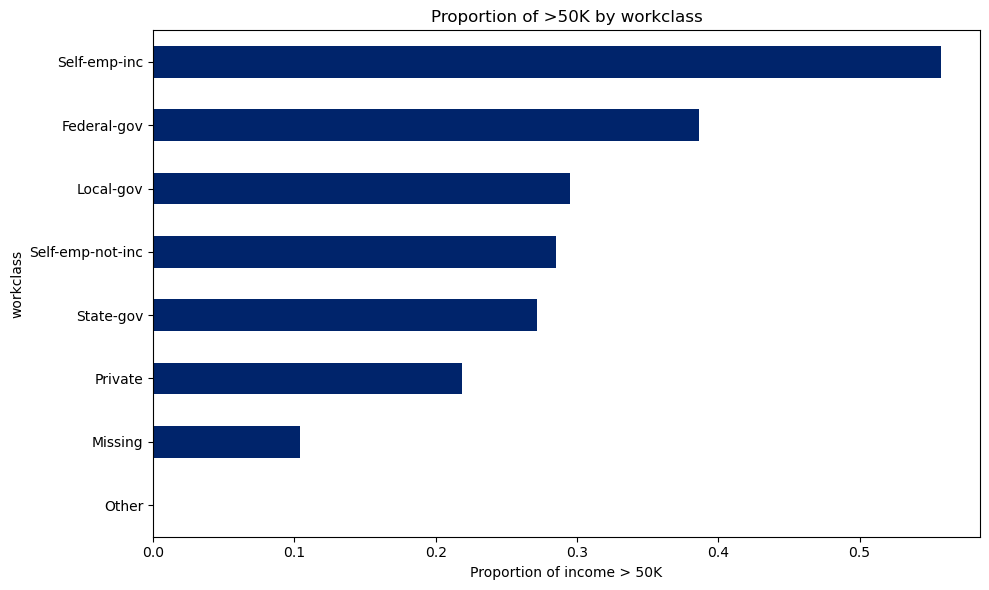

--- workclass ---
workclass
Self-emp-inc        0.557348
Federal-gov         0.386458
Local-gov           0.294792
Self-emp-not-inc    0.285039
State-gov           0.271957
Private             0.218807
Missing             0.104031
Other               0.000000
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


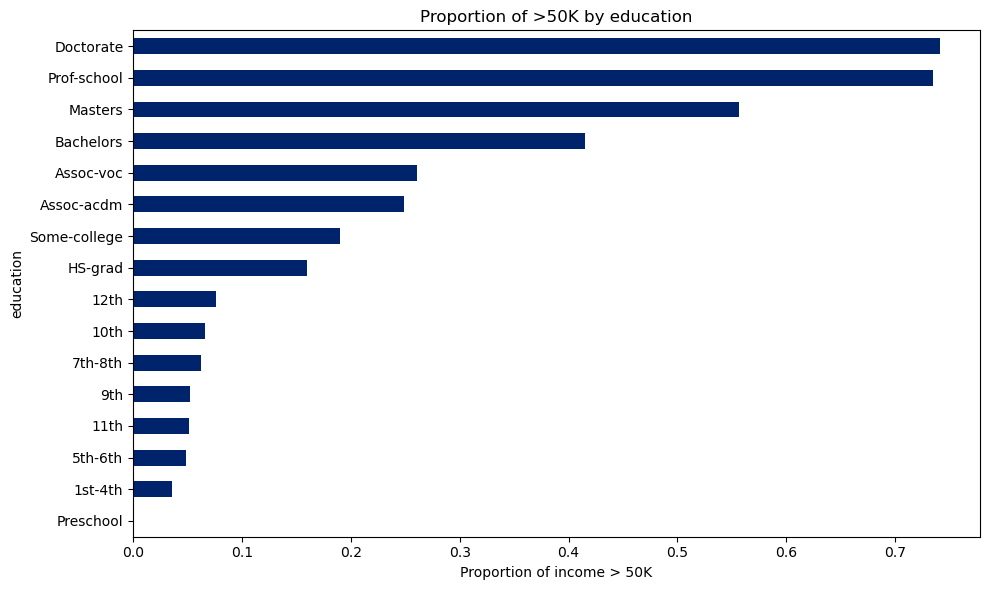

--- education ---
education
Doctorate       0.740920
Prof-school     0.734375
Masters         0.556911
Bachelors       0.414908
Assoc-voc       0.261216
Assoc-acdm      0.248360
Some-college    0.190332
HS-grad         0.159520
12th            0.076212
10th            0.066452
7th-8th         0.062016
9th             0.052529
11th            0.051064
5th-6th         0.048193
1st-4th         0.036145
Preschool       0.000000
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


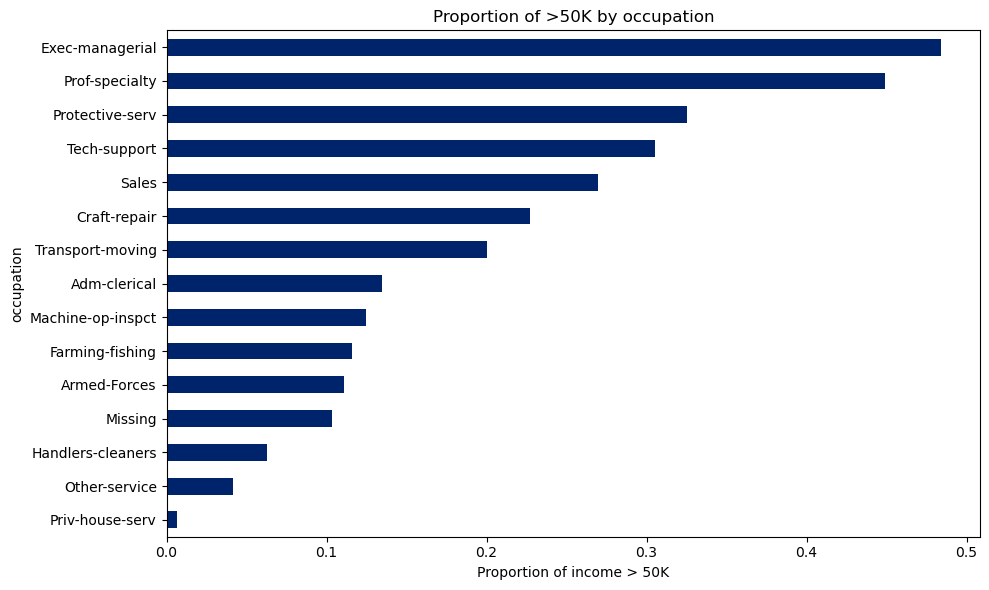

--- occupation ---
occupation
Exec-managerial      0.484133
Prof-specialty       0.449226
Protective-serv      0.325116
Tech-support         0.305286
Sales                0.269315
Craft-repair         0.226917
Transport-moving     0.200376
Adm-clerical         0.134554
Machine-op-inspct    0.124500
Farming-fishing      0.115927
Armed-Forces         0.111111
Missing              0.103635
Handlers-cleaners    0.062820
Other-service        0.041629
Priv-house-serv      0.006803
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


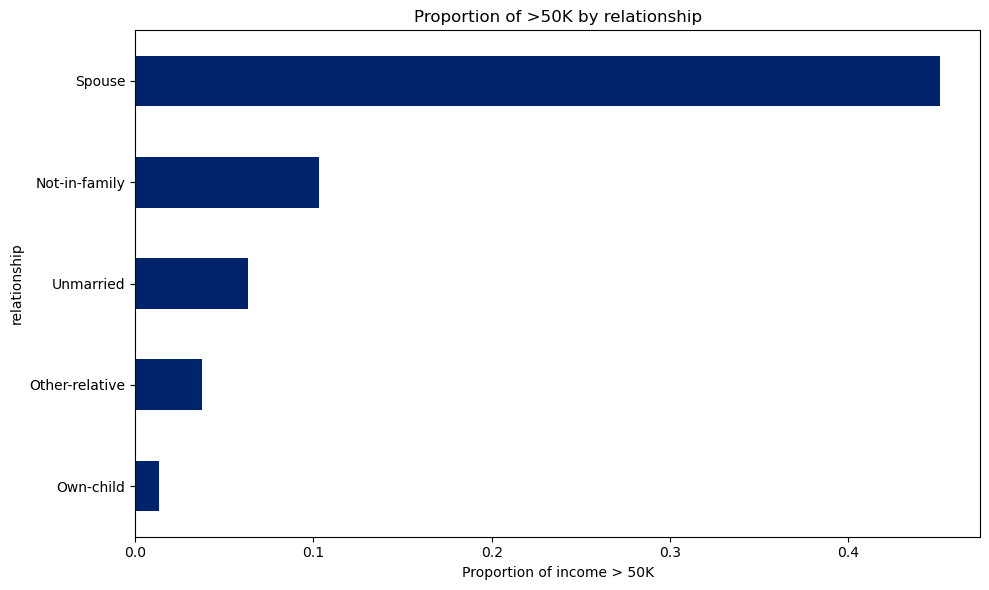

--- relationship ---
relationship
Spouse            0.451440
Not-in-family     0.103232
Unmarried         0.063280
Other-relative    0.037717
Own-child         0.013231
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


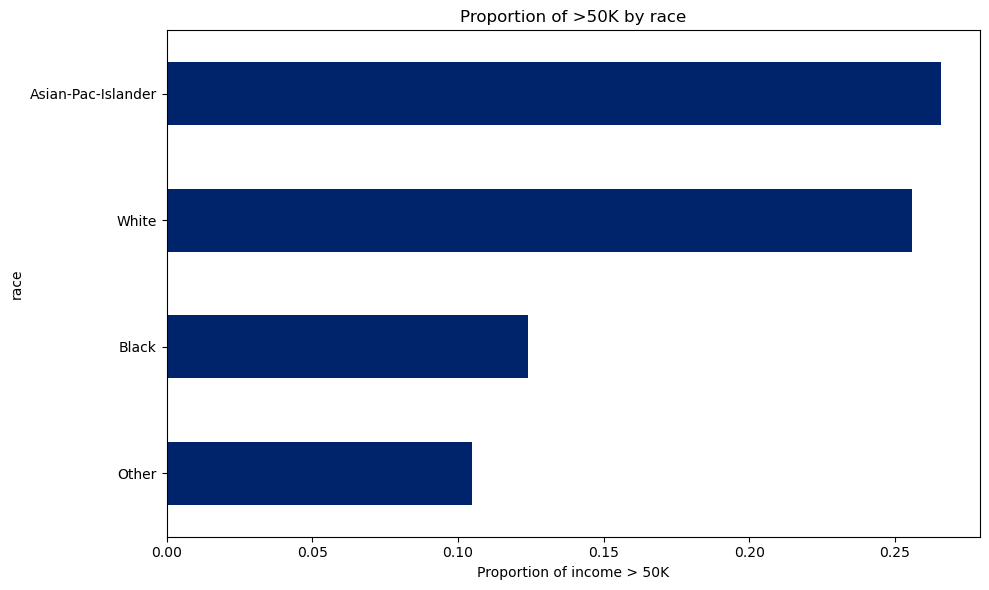

--- race ---
race
Asian-Pac-Islander    0.265896
White                 0.255981
Black                 0.123959
Other                 0.104811
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby(col)['income'].mean().sort_values()


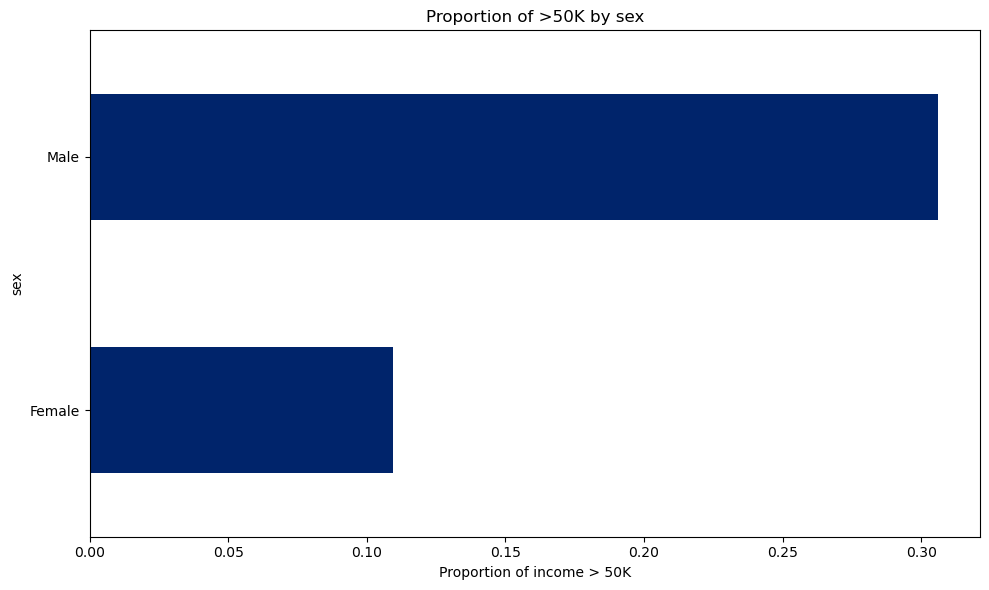

--- sex ---
sex
Male      0.305855
Female    0.109552
Name: income, dtype: float64




C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(col)['income'].mean().sort_values(ascending=False))
C:\Users\yes i can\AppData\Local\Temp\ipykernel_13668\3738433616.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(col).agg(


In [239]:

# Analyze the relationship between categorical features and income
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income') # Remove target variable

for col in categorical_cols:
    
    income_rate = df.groupby(col)['income'].mean().sort_values()
    plt.figure(figsize=(10, 6))
    income_rate.plot(kind='barh', color='#00246B')
    plt.title(f"Proportion of >50K by {col}")
    plt.xlabel("Proportion of income > 50K")
    plt.tight_layout()
    plt.show()
    print(f"--- {col} ---")
    # Group by the column and calculate the mean of the target variable
    # We can do this because the target is 0 or 1
    print(df.groupby(col)['income'].mean().sort_values(ascending=False))
    print("\n")

summary = df.groupby(col).agg(
    income_rate=('income', 'mean'),
    count=('income', 'size')
).sort_values(by='income_rate', ascending=False)